In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
import scipy.stats as sps
import math
import statsmodels.api as statsmodel
from scipy.stats import norm
from scipy.stats import mannwhitneyu
from tqdm.auto import tqdm

### Загрузим данные и проведем небольшой анализ

In [2]:
reg_df = pd.read_csv ('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-chernobrivets/shared/problem1-reg_data.csv', sep=';')

In [3]:
reg_df.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
# Посмотрим кол-во строк и типы данных
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [5]:
# Проверим количество уникальным пользователей
reg_df.uid.nunique()

1000000

In [6]:
# Перепроверим себя, узнав кол-во дубликатов
reg_df.uid.duplicated().sum()

0

In [7]:
# Проверим кол-во пустых значений
reg_df.isna().sum()

reg_ts    0
uid       0
dtype: int64

#### Аналогичные операции проделаем со вторым датасетом

In [8]:
auth_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-chernobrivets/shared/problem1-auth_data.csv', sep=';')

In [9]:
auth_df.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [10]:
auth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [11]:
auth_df.uid.nunique()

1000000

In [12]:
# Перепроверим себя, удалив дубликаты
auth_df.uid.drop_duplicates().count()

1000000

In [13]:
auth_df.isna().sum()

auth_ts    0
uid        0
dtype: int64

#### Кол-во уникальных пользователей совпадает. Пустые значения отсутствуют.
#### В обоих датасетах колонки дат имеют не соответствующий тип данных, также указан в секундах, что необходимо учесть при напиcании функции.
______

## Задание 1
### Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

### Для написания функции нам необходимо преобразовать наши датасеты внутри самой функции, т.к. нам будут необходимы данные в формате datetime. Но так как данные к нам поступают в секундах и формате int64, то предварительно их преобразовывать до написания функции не имеет смысла.

In [14]:
def retention (registration, authentication, start_day=None, finish_day=None, visualisation=None):
    
    # Переведем даты к формату datetime
    registration ['registration_date'] = pd.to_datetime(reg_df['reg_ts'], unit='s').dt.date
    authentication ['authentication_date'] = pd.to_datetime(auth_df['auth_ts'], unit='s').dt.date
    
    # Задаем диапозон времени для просмотра retention
    registration = registration.query('registration_date >= @start_day')
    authentication = authentication.query('authentication_date <= @finish_day')
    
    # Соеденим 2 датасета
    df = pd.merge(authentication, registration, on='uid')
    
    # Посчитаем количество дней от момента регистрации до момента входа в приложение
    df['days_since_registration'] = (df['authentication_date'] - df['registration_date']).dt.days + 1
    
    # Перед тем как посчитать retention, необходимо разбить на когорты
    cohort = df.groupby(['registration_date', 'days_since_registration'])['uid'].nunique().reset_index()
    cohort = cohort.pivot(index='registration_date', columns='days_since_registration', values='uid')
    retention = cohort.divide(cohort[1], axis=0).round(2)
    
    # Визуализация
    if  (visualisation):
        plt.figure(figsize=(20, 14))
        plt.title('Retention')
        sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.1)
        plt.show()
    else: 
        return retention.fillna("—")    

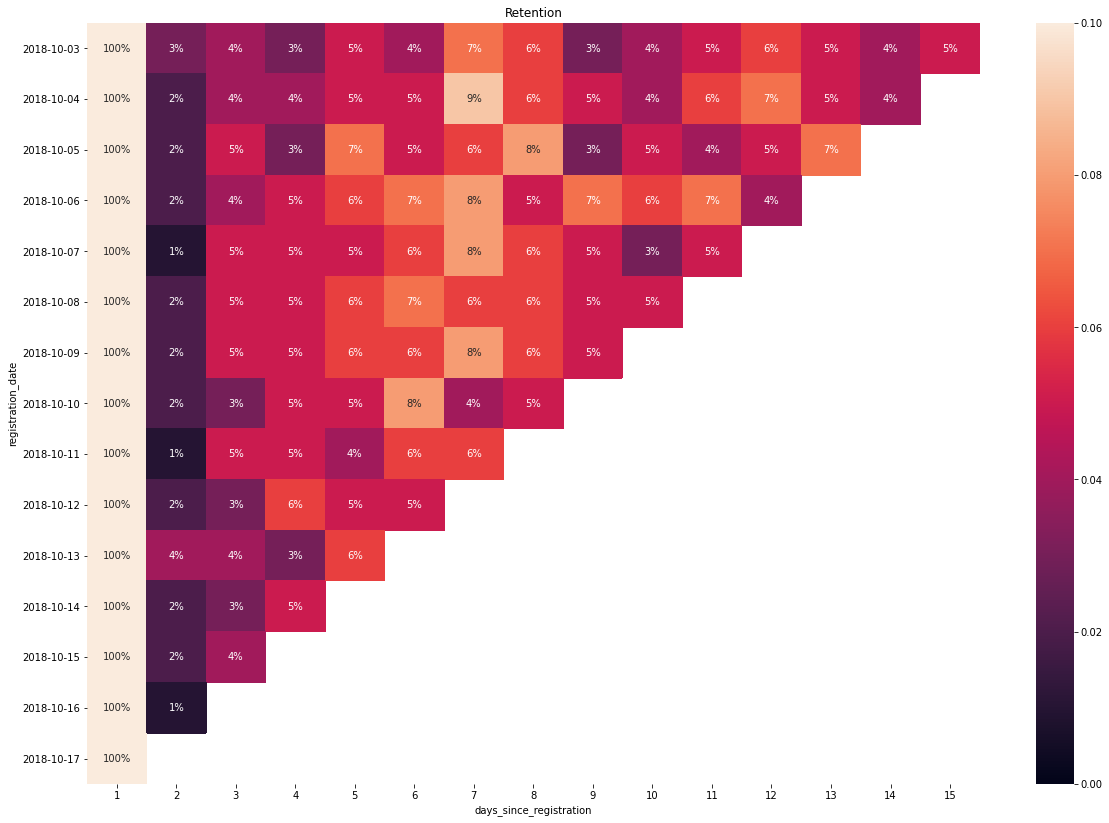

In [15]:
# Проверим работу функции
retention(reg_df, auth_df, datetime.date(2018, 10, 3), datetime.date(2018, 10, 17), visualisation=True)

#### Функция работает.

## Задание 2
### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [16]:
exp_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-chernobrivets/Проект_1_Задание_2.csv', sep=';')

In [17]:
exp_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [18]:
exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


### Разобьем на группы

In [19]:
# Группа а
group_a = exp_df.query('testgroup == "a"')
group_a.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [20]:
group_a.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [21]:
# Группа b
group_b = exp_df.query('testgroup == "b"')
group_b.head()

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b


In [22]:
group_b.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [23]:
# Отберем в группах платящих пользователей
control = group_a.query('revenue > 0')
test = group_b.query('revenue > 0')
df_rev = exp_df.query('revenue > 0')

В контрольной группе максимальное значение "revenue" выше, чем в тестовой:
* воможно есть проблема в сплитовании;
* были какие-то распродажи с большим дисконтом (т.к. нам об этом ничего не известно, поэтому оставим первый вариант)

In [24]:
# Общий датасет с обеими группами и доходом
revenue_df = exp_df.query('revenue > 0')
revenue_df.head()

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


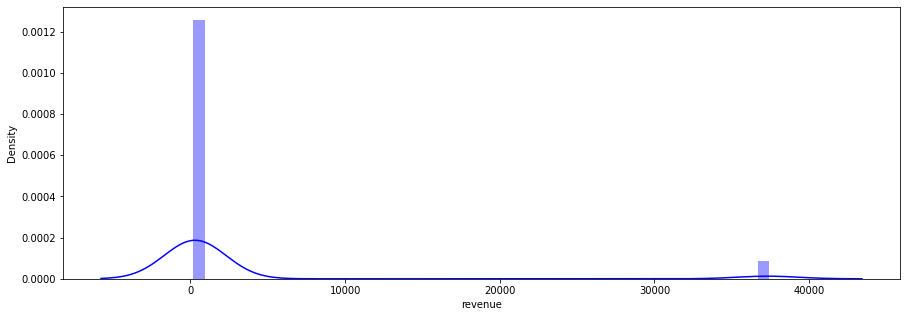

In [25]:
plt.figure(figsize=(15, 5))
sns.distplot(control.revenue, color = 'blue')
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


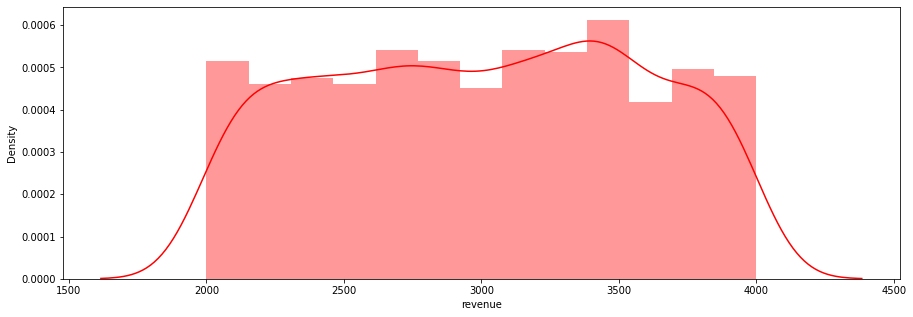

In [26]:
plt.figure(figsize=(15, 5))
sns.distplot(test.revenue, color = 'red')
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


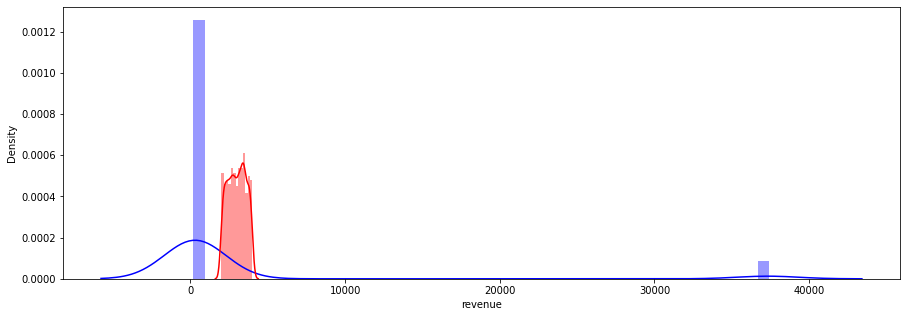

In [27]:
plt.figure(figsize=(15, 5))
sns.distplot(control.revenue, color = 'blue')
sns.distplot(test.revenue, color = 'red')
plt.show()

<Figure size 1080x360 with 0 Axes>

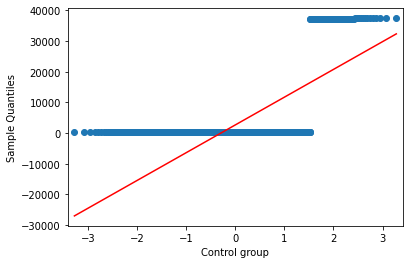

<Figure size 1080x360 with 0 Axes>

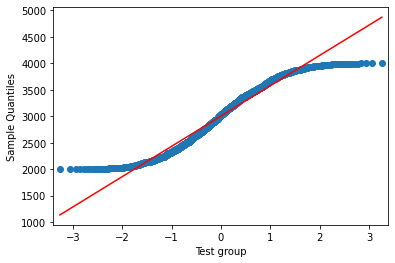

In [28]:
plt.figure(figsize=(15, 5))
statsmodel.qqplot(control.revenue, line = 's')
plt.xlabel('Control group')


plt.figure(figsize=(15, 5))
statsmodel.qqplot(test.revenue, line = 's')
plt.xlabel('Test group')
plt.show()

#### Т.к. по первому графику сложно определить какого типа распределением являются данные, то разделим их.

Text(0.5, 0, 'Control group')

<Figure size 1080x360 with 0 Axes>

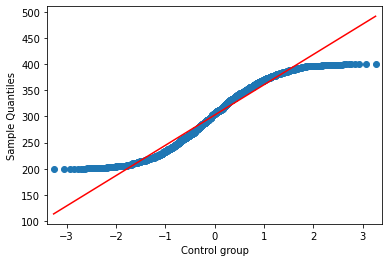

In [29]:
plt.figure(figsize=(15, 5))
statsmodel.qqplot(control.query('revenue < 5000').revenue, line = 's')
plt.xlabel('Control group')

Text(0.5, 0, 'Control group')

<Figure size 1080x360 with 0 Axes>

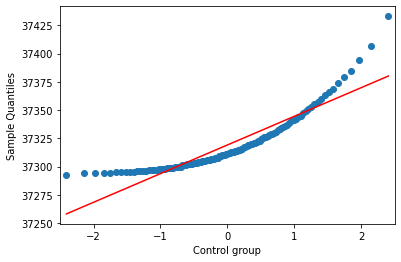

In [30]:
plt.figure(figsize=(15, 5))
statsmodel.qqplot(control.query('revenue > 5000').revenue, line = 's')
plt.xlabel('Control group')

### Таким образом, можно сделать вывод, что распределения не нормальные: контрольная группа больше относится к бимодальному распределению, т.к. у нее есть 2 вида продаж - мелкие и большие. Тестовая больше относится к [дискретному](https://math.spbu.ru/ru/Archive/Courses/jvr/DA_html/_lec_1_07.html) равномерному распределению.

In [31]:
# Расчитаем, какой процент пользователей совершил большие покупки:

# Узнаем, какое кол-во пользователей совершали покупки свыше 5000
high_pay_users = control.query('revenue > 5000').user_id.count()

# Общее кол-во платящих пользователей
control_users = control.user_id.count()

per_high_pay_users = round(high_pay_users / control_users * 100, 2)
per_high_pay_users

6.38

In [32]:
# Расчитаем, какой процент от общего дохода составил доход с больших покупок:

# Расчитаем доход с больших покупок
high_pay_rev = control.query('revenue > 5000').revenue.sum()

# Рассчитаем общий доход
total_rev = control.revenue.sum()

per_high_pay_rev = round(high_pay_rev / total_rev * 100, 2)
per_high_pay_rev

89.37

#### Проанализируем метрики ARPPU, ARPU, conversion так как они завязаны на среднем чеке пользователей
ARPPU = Доход / Число клиентов

Conversion = Число пл. пользователей / общее число пользователей

ARPU = Доход / Число пользователей


In [33]:
# Объявим фрейм для метрик
metrics = pd.DataFrame(columns=['control', 'test'])

#ARPPU
test_arppu = test.revenue.sum() / test.shape[0]
control_arppu = control.revenue.sum() / control.shape[0]
metrics = metrics.append({'test':test_arppu,'control':control_arppu}, ignore_index=True)

#ARPU
test_arpu = group_b.revenue.sum() / group_b.shape[0]
control_arpu = group_a.revenue.sum() / group_a.shape[0]
metrics = metrics.append({'test':test_arpu,'control':control_arpu}, ignore_index=True)

#Conversion
test_conv = (test.shape[0] / group_b.shape[0])
control_conv = (control.shape[0] / group_a.shape[0])
metrics = metrics.append({'test':test_conv,'control':control_conv}, ignore_index=True)

# Еще 1 способ рассчета конверсии
# test_arpu = test_conv * test_arppu
# control_arpu = control_conv * control_arppu
# metrics = metrics.append({'test':test_arpu,'control':control_arpu}, ignore_index=True)

my_index = ['ARPPU', 'ARPU', 'Conversion']
metrics.index = my_index

metrics.apply(lambda x : round(x, 3)) 

,control,test
ARPPU,2663.998,3003.658
ARPU,25.414,26.751
Conversion,0.010,0.009


## Проверим нормальность распределений и гомогенность дисперсий выборок.
## Использовать будем normaltest и критерий Левена.

In [34]:
stats.normaltest(control.revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [35]:
stats.normaltest(test.revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

#### В обоих случаях мы отклоняем нулевую гипотезу о нормальности распределений выборок, т.к. pvalue < 0.05

In [36]:
stats.levene(control.revenue, test.revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

#### Отклоняем нулевую гипотезу о равенстве дисперсий, т.к. pvalue < 0.05

### Выбор метода. Мы имеем ненормальные распределения и неравенства дисперсий, что подталкивает на то, что t-test применяться не может, но также это сказано для выборок (менее 30). В нашем случае, мы не будем рисковать и воспользуемся менее мощным методом bootstrap, используя в статистике среднее значение.

In [37]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  #извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

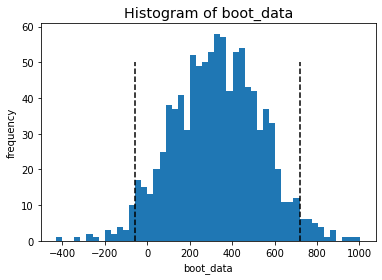

In [38]:
booted_test = get_bootstrap(test.revenue, control.revenue, statistic=np.mean) 

In [39]:
# альфа
booted_test['p_value'].round(3)

0.111

In [40]:
# ДИ
booted_test['ci']

,0
0.025,-59.445319
0.975,719.693711


# Выводы по заданию:
### Распределения в наших данных разнятся. В контрольной группе есть пользователи (~6%), которые платят бОльшие суммы, остальные же ограничиваются 5000 руб. Пользователи тестовой группы платять от 2000 до 4000.
### Я бы оставил тестовую группу, т.к. при оттоке пользователей, которые платят бОльшие деньги, наши метрики сильно не просядут.
### Результаты A/B теста показали, что значимых различий в контрольной и тестовой выборках нет.
### Есть предложение произвести А/А тест и при необходимости изменить выборку контрольной группы,  убрать доходных пользователей и провести А/В тест заново, т.к. есть подозрение на ошибку в сплитовании.

# Задание 3
### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени.
### В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. 

### С помощью каких метрик можно оценить результаты последнего прошедшего события?

Оценивать результаты можно с помощью стандартных метрик:

DAU, WAU, MAU - сравнение кол-ва пользователей в тематические дни и обычные;

Конверсия (CR) - отношение пользователей перешедших в тематическое событие к общему кол-ву пользователей.

### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Churn rate - отток пользователей.

Данная метрика покажет отток пользователей. Можно проверить метрику до введения отката на уровень назад и после, посмотреть поведение метрики, насколько игроки принимают такие правила игры.